In this post we will see how to perform Outlier Detection using LightSOM.
Lets load a data set.
The original lymphography dataset from UCI machine learning repository is a classification dataset. It is a multi-class dataset having four classes, but two of them are quite small (2 and 4 data records). Therefore, those two small classes are merged and considered as outliers compared to other two large classes (81 and 61 data records).
4.1% of the data set are outliers

In [5]:
import scipy.io
import pandas as pd
lympho = pd.read_csv('data/lympho.csv')


In [6]:
lympho.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,target
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,2,1,2,1,2,2,1,1,2,1,1,1,2,1
2,3,2,2,2,2,2,2,2,3,1,1,2,2,8,1,2,2,4,1
3,3,1,1,1,2,2,2,1,3,1,1,4,2,5,3,1,2,4,1
4,3,2,2,2,2,2,2,1,2,2,2,4,2,4,3,2,2,7,1


In [7]:
import sys, os, errno
import numpy as np

sys.path.append('../..')

from lightSOM import SOM

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [10]:
data=lympho.drop(columns='target').values
target=lympho['target']

What we expect from a good outlier algorithm is that all the samples far away from the two main clusters are labeled as outliers. 
Considering the SOM algorithm, this can be obtained considering as outliers the data points that have a high quantization error.

We need then to:
- train a SOM,
- compute the quantization error,
- set a treshold for the quantization error:

In [49]:
net=SOM().create(25, 25, data, target=target,pci=True, pbc=False)

net.train(0.5, epochs=20000, random_order=True, keep_error_history=False)

outliers_percentage=0.041



Periodic Boundary Conditions inactive.
The weights will be initialised with PCA.
 [ 20000 / 20000 ] 100% - 0:00:00 left 
 quantization error: 0.9496689309624757

 topological error: 0.0
Training SOM... done!


In [50]:
from lightSOM.visualization.som_view import SOMView
vhts  = SOMView(net, 10,10, text_size=10)
vhts.plot_training_errors()

Error treshold: 1.339027497192578


Text(0, 0.5, 'frequency')

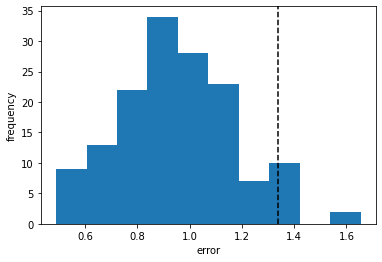

In [51]:
quantization_errors = np.linalg.norm(net.quantization(data) - data, axis=1)
error_treshold = np.percentile(quantization_errors, 
                               100*(1-outliers_percentage))

print('Error treshold:', error_treshold)

is_outlier = quantization_errors > error_treshold

plt.hist(quantization_errors)
plt.axvline(error_treshold, color='k', linestyle='--')
plt.xlabel('error')
plt.ylabel('frequency')

In [52]:
is_outlier

array([False, False,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

This histogram shows the frequency of the quantization error. The dashed line represents the treshold picked to label the outliers. We can see that most of the samples have a low quantization error and the errors higher than the treshold are much more rare. (Notice that we were able to set a good treshold as we knew the percentage of outliers in our data. This is usually a parameter to tune experimentally.)

We are now ready to plot our dataset again highlighting the outliers with a different color:

In [53]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(data)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 148 samples in 0.000s...
[t-SNE] Computed neighbors for 148 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 148 / 148
[t-SNE] Mean sigma: 1.897750
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.769157
[t-SNE] KL divergence after 500 iterations: 0.247912


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

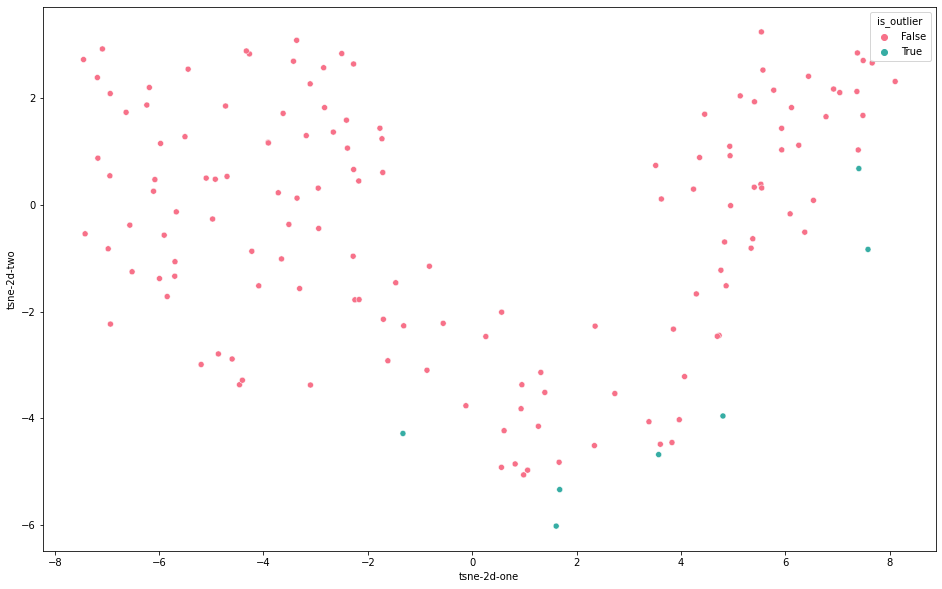

In [54]:
import seaborn as sns
lympho['tsne-2d-one'] = tsne_results[:,0]
lympho['tsne-2d-two'] = tsne_results[:,1]
lympho['is_outlier']=is_outlier
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="is_outlier",
    palette=sns.color_palette("husl", 2),
    data=lympho,
    legend="full"
)

Out of 6 outliers 4 are detected correctly. However due to the randomness of the algorithm you may get slightly diffetent resutls.

In [55]:

print('accuracy: ', np.sum(is_outlier[0:6]==target[0:6])/6)

accuracy:  0.6666666666666666


We can also try the same with different options. Tneighhis time using a **mexican hat** neigborhood function.

In [76]:

net=SOM().create(20, 20, data, neighborhood="mexican_hat", target=target,pci=False, pbc=True)

net.train(0.5, start_sigma=0.5, epochs=5000, random_order=True, keep_error_history=True)


Periodic Boundary Conditions active.
The weights will be initialised randomly.
 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 2.297291279702089

 topological error: 1.0
Training SOM... done!


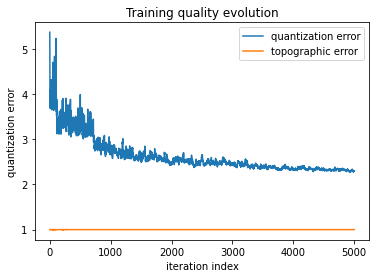

In [77]:
from lightSOM.visualization.som_view import SOMView
vhts  = SOMView(net, 10,10, text_size=10)
vhts.plot_training_errors()

Error treshold: 3.406529986500598


Text(0, 0.5, 'frequency')

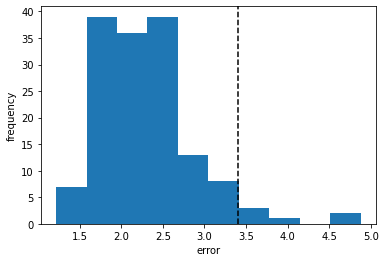

In [78]:
quantization_errors = np.linalg.norm(net.quantization(data) - data, axis=1)
error_treshold = np.percentile(quantization_errors, 
                               100*(1-outliers_percentage))

print('Error treshold:', error_treshold)

is_outlier = quantization_errors > error_treshold

plt.hist(quantization_errors)
plt.axvline(error_treshold, color='k', linestyle='--')
plt.xlabel('error')
plt.ylabel('frequency')

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

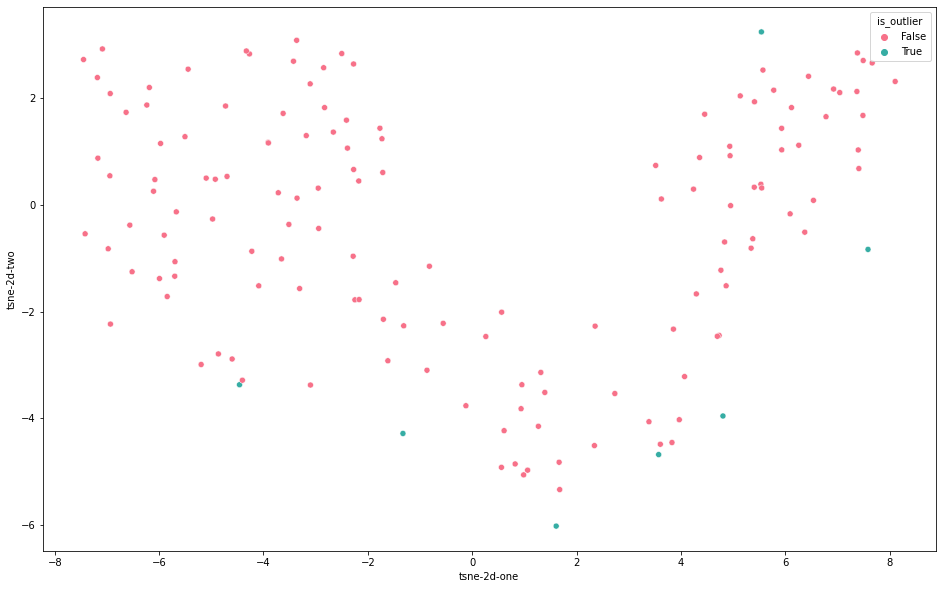

In [79]:
import seaborn as sns
lympho['tsne-2d-one'] = tsne_results[:,0]
lympho['tsne-2d-two'] = tsne_results[:,1]
lympho['is_outlier']=is_outlier
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="is_outlier",
    palette=sns.color_palette("husl", 2),
    data=lympho,
    legend="full"
)

Out of 6 outliers 5 are detected correctly. Different runs can yield different results.

In [80]:
print('accuracy: ', np.sum(is_outlier[0:6]==target[0:6])/6)

accuracy:  0.5
